In [1]:
from libraries import *

# Simulation Setup

In [3]:
# Parameters for simulation
ITER                    = 2                                 # Iteration count
SIMULATION_INTERVAL     = 40                                # Simulation interval per iteration
TOT_SIMULATION_INTERVAL = max(100, SIMULATION_INTERVAL)     # Total simulation interval
T_START                 = 40                                # Starting time step

SYNTH_BRAIN             = 0                                 # Whether to choose the synthetic topology (0) or BRAIN (1)

gp.setParam("OutputFlag", 0)                                # Disables Gurobi logs (Affects all models created afterward)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-18


### 5G Infrastructure Setup

In [5]:
V_P_S = V_P_R = E_P = E_P_l = L = L_pqi = []
V_P_S, V_P_R, E_P, E_P_l, L, L_pqi = init_setup_synth() if SYNTH_BRAIN == 0 else init_setup_brain()

### Slice Request Setup

In [7]:
# Initialize slice types and probabilities
sr_types = create_sr_resources()
sr_probs = [0.7, 0.15, 0.1, 0.05]  # Probabilities for each type

# Generate SR list
sr_list, sr_type_list = init_setup_sr(ITER, TOT_SIMULATION_INTERVAL, sr_types, sr_probs)

### Infrastructure Graph

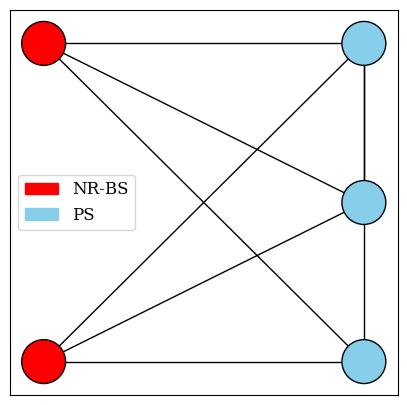

In [9]:
plot_synth(V_P_S, V_P_R, E_P) if SYNTH_BRAIN == 0 else plot_brain(V_P_S, V_P_R, E_P)

### Data Templates

In [11]:
data = {}

algs = ["fgr", "opt", "iar", "dtr", "rnr"]
for a in algs:
    data[a] = {
        "profit":  np.zeros((ITER, T_START+SIMULATION_INTERVAL)),
        "violat":  np.zeros((ITER, T_START+SIMULATION_INTERVAL, 5)), ## 5 for Total (0), Radio (1), Bandwidth (2), MIPS (3), and Delay (4)
        "migrat":  np.zeros((ITER, T_START+SIMULATION_INTERVAL)),
        "deploy":  np.zeros((ITER, T_START+SIMULATION_INTERVAL, 4)),
        "overhe":  np.zeros((ITER, T_START+SIMULATION_INTERVAL, 4)),
        "reseff":  np.zeros((ITER, T_START+SIMULATION_INTERVAL, 4)),
        "reject":  np.zeros((ITER, T_START+SIMULATION_INTERVAL, 3)),
        "time":    np.zeros((ITER, T_START+SIMULATION_INTERVAL)),
        "vars":    [[{} for _ in range(T_START+SIMULATION_INTERVAL)] for _ in range(ITER)],
        "feasib":  np.zeros((ITER, T_START+SIMULATION_INTERVAL)),
        "timeou":  np.zeros((ITER, T_START+SIMULATION_INTERVAL)),
        "R_t":     [[[] for _ in range(T_START+SIMULATION_INTERVAL)] for _ in range(ITER)]
    }

# Running the Simulation

### Saved Data Reuse (from previous runs)

In [14]:
keys = ["profit", "violat", "migrat", "deploy", "overhe", "reseff", "reject", "time", "vars", "feasib", "timeou", "R_t"]
data_loaded = {}
if T_START > 0:
    for a in algs:
        # Load the lists from the file
        with open(f'saved_data/{a}.pkl', 'rb') as file:
            data_loaded = pickle.load(file)
        
        data[a]["profit"][:, :T_START]    = data_loaded["profit"][:, :T_START]
        data[a]["violat"][:, :T_START, :] = data_loaded["violat"][:, :T_START, :]
        data[a]["migrat"][:, :T_START]    = data_loaded["migrat"][:, :T_START]
        data[a]["deploy"][:, :T_START, :] = data_loaded["deploy"][:, :T_START, :]
        data[a]["overhe"][:, :T_START, :] = data_loaded["overhe"][:, :T_START, :]
        data[a]["reseff"][:, :T_START, :] = data_loaded["reseff"][:, :T_START, :]
        data[a]["reject"][:, :T_START, :] = data_loaded["reject"][:, :T_START, :]
        data[a]["time"][:, :T_START]      = data_loaded["time"][:, :T_START]
        data[a]["feasib"][:, :T_START]    = data_loaded["feasib"][:, :T_START]
        data[a]["timeou"][:, :T_START]    = data_loaded["timeou"][:, :T_START]
        
        # Handle dictionaries and lists separately
        for i in range(ITER):
            for t in range(T_START):
                data[a]["vars"][i][t] = data_loaded["vars"][i][t]
                data[a]["R_t"][i][t]  = data_loaded["R_t"][i][t]

### Simulation Run Template

In [16]:
def run_simulation(alg, ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, func, limit=None):
    """
    Generic simulation function for different algorithms
    
    Parameters:
        alg (str): "fgr", "opt", "iar", "dtr", "rnr"
        ITER (int): Number of iterations
        SIMULATION_INTERVAL (int): Simulation time steps
        sr_list (list): Service request list
        V_P_S, V_P_R, E_P, E_P_l, L, L_pqi: Network elements
        func (function): Optimization function to call (opt_iter or dtr_iter)
        limit (float, optional): Limit parameter for "dtr" algorithm
    """
    file_path = f'saved_data/{alg}.pkl'
    
    for iter in range(ITER):
        if T_START == 0:
            m = gp.Model("e2esliceiso")
            if alg == "fgr":
                m.write(f'saved_model/model_backup_fgr_{iter}.mps')
                m.write(f'saved_model/model_backup_fgr_opt_{iter}.mps')
                m.write(f'saved_model/model_backup_fgr_iar_{iter}.mps')
                m.write(f'saved_model/model_backup_fgr_dtr_{iter}.mps')
                m.write(f'saved_model/model_backup_fgr_rnr_{iter}.mps')
            else:
                m.write(f'saved_model/model_backup_{alg}_{iter}.mps')
        
        for t in range(T_START, T_START+SIMULATION_INTERVAL):
            print(f"\niteration: {iter}, Time step: {t}")
            
            prev_profit = data[alg]["profit"][iter][t-1] if t > 0 else 0
            prev_R_t = data[alg]["R_t"][iter][t-1] if t > 0 else []
            
            if alg == "fgr":    # "dtr" requires an additional limit parameter
                result = func(limit, prev_profit, iter, t, sr_list[iter * SIMULATION_INTERVAL + t], prev_R_t, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi)
            elif alg == "dtr":  # "dtr" requires an additional limit parameter + f_fgr = 0
                result = func(limit, prev_profit, iter, t, sr_list[iter * SIMULATION_INTERVAL + t], prev_R_t, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, 0)
            else:
                result = func(prev_profit, iter, t, sr_list[iter * SIMULATION_INTERVAL + t], prev_R_t, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, 0)
            
            keys = ["profit", "violat", "migrat", "deploy", "overhe", "reseff", "reject", "time", "vars", "feasib", "timeou", "R_t"]
            
            if result[9] == 1:  # feasible
                for idx_k, k in enumerate(keys):
                    data[alg][k][iter][t] = result[idx_k]
            else:  # infeasible
                if t > 0:
                    for idx_k, k in enumerate(keys):
                        data[alg][k][iter][t] = data[alg][k][iter][t-1]
                    data[alg]["reject"][iter][t] = result[6]
                    data[alg]["time"][iter][t]   = result[7]
                    data[alg]["feasib"][iter][t] = result[9]
                    data[alg]["timeou"][iter][t] = result[10]
    
    # Save updated data
    with open(file_path, 'wb') as file:
        pickle.dump(data[alg], file)
    
    return data

## OPT

In [18]:
data = run_simulation("opt", ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, opt_iter)


iteration: 0, Time step: 40
+-------------------------+--------------------+
| Category                | Value              |
+=========================+====================+
| Algorithm               | RNR                |
+-------------------------+--------------------+
| Request Isolation Level | (0, 1)             |
+-------------------------+--------------------+
| Profit                  | 23977.11877772702  |
+-------------------------+--------------------+
| Allocation Time         | 0.4524838924407959 |
+-------------------------+--------------------+
| Radio Violation Cost    | 90.0               |
+-------------------------+--------------------+
| MIPS Violation Cost     | 509.54545454545206 |
+-------------------------+--------------------+
| Overhead Cost           | 3538.9545454545455 |
+-------------------------+--------------------+

iteration: 0, Time step: 41
+---------------------------+------------------------------+
| Category                  | Value             

## DTR

In [20]:
LIMIT = 0.6
data = run_simulation("dtr", ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, dtr_iter, limit=LIMIT)


iteration: 0, Time step: 40
Infeasible rounding with infeasible constraints: [4]
+-----------------------------+-----------+
| Category                    |     Value |
+=============================+===========+
| Request Isolation Level     | 0         |
+-----------------------------+-----------+
| Request Isolation Sub-level | 1         |
+-----------------------------+-----------+
| Allocation Time             | 0.0569487 |
+-----------------------------+-----------+
| Feasible                    | 0         |
+-----------------------------+-----------+
| Timeout                     | 0         |
+-----------------------------+-----------+

iteration: 0, Time step: 41
Infeasible rounding with infeasible constraints: [4]
+-----------------------------+-----------+
| Category                    |     Value |
+=============================+===========+
| Request Isolation Level     | 0         |
+-----------------------------+-----------+
| Request Isolation Sub-level | 1         |


## RNR

In [22]:
data = run_simulation("rnr", ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, rnr_iter)


iteration: 0, Time step: 40
Infeasible rounding with infeasible constraints: [4]
+-----------------------------+-----------+
| Category                    |     Value |
+=============================+===========+
| Request Isolation Level     | 0         |
+-----------------------------+-----------+
| Request Isolation Sub-level | 1         |
+-----------------------------+-----------+
| Allocation Time             | 0.0476675 |
+-----------------------------+-----------+
| Feasible                    | 0         |
+-----------------------------+-----------+
| Timeout                     | 0         |
+-----------------------------+-----------+

iteration: 0, Time step: 41
Infeasible rounding with infeasible constraints: [4]
+-----------------------------+-----------+
| Category                    |     Value |
+=============================+===========+
| Request Isolation Level     | 0         |
+-----------------------------+-----------+
| Request Isolation Sub-level | 1         |


## IAR

In [24]:
data = run_simulation("iar", ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, iar_iter)


iteration: 0, Time step: 40
+-------------------------+---------------------+
| Category                | Value               |
+=========================+=====================+
| Algorithm               | RNR                 |
+-------------------------+---------------------+
| Request Isolation Level | (0, 1)              |
+-------------------------+---------------------+
| Profit                  | 20960.391505002975  |
+-------------------------+---------------------+
| Allocation Time         | 0.00508427619934082 |
+-------------------------+---------------------+
| MIPS Violation Cost     | 1507.2727272727268  |
+-------------------------+---------------------+
| Overhead Cost           | 1803.7272727272727  |
+-------------------------+---------------------+

iteration: 0, Time step: 41
+-------------------------+-------------------+
| Category                | Value             |
+=========================+===================+
| Algorithm               | RNR               |


## 5Guard

In [26]:
LIMIT = 0.2

data = run_simulation("fgr", ITER, T_START, SIMULATION_INTERVAL, sr_list, V_P_S, V_P_R, E_P, E_P_l, L, L_pqi, fgr_iter, limit=LIMIT)

# Load the lists from the file
with open('saved_data/fgr.pkl', 'rb') as file:
    data_loaded = pickle.load(file)


iteration: 0, Time step: 40
+-----------------------------+----------+
| Category                    |    Value |
+=============================+==========+
| Request Isolation Level     | 0        |
+-----------------------------+----------+
| Request Isolation Sub-level | 1        |
+-----------------------------+----------+
| Allocation Time             | 0.193115 |
+-----------------------------+----------+
| Feasible                    | 0        |
+-----------------------------+----------+
| Timeout                     | 0        |
+-----------------------------+----------+
+---------------------------+-------------------------------+
| Category                  | Value                         |
+===========================+===============================+
| Algorithm                 | RNR                           |
+---------------------------+-------------------------------+
| Request Isolation Level   | (0, 1)                        |
+---------------------------+-----------

# Results

### Find the data average and error bars

In [29]:
data_avg = copy.deepcopy(data)

kpis = ["profit", "violat", "migrat", "deploy", "overhe", "reseff", "reject", "time"]

for a in algs:
    for k in kpis:
        data_avg[a][k]  = np.sum(data[a][k], axis=0) / ITER

### Plot Settings

In [31]:
plt.rcParams['font.family']  = 'DeJavu Serif'
plt.rcParams['font.serif']   = ['Times New Roman']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42

# Constants
bar_width       = 0.13
markevery       = 10
linewidth       = 5
marker_size     = 17
markeredgewidth = 4
step            = 5  # Error bars frequency

tick_label_size, legend_font_size, xlabel_font_size, ylabel_font_size = 25, 18, 23, 23

kpi1  = ["reject"]
kpis2 = ["profit", "migrat"]
kpis3 = ["violat", "deploy", "overhe", "reseff"]
kpi4  = ["time"]

xpoints = range(0, T_START+SIMULATION_INTERVAL)
ypoints = data_avg.copy()
yerrors_low  = {alg: {k: np.min(data[a][k], axis=0) for k in kpis2+kpis3+kpi4} for alg in algs}  # Lower bound errors
yerrors_high = {alg: {k: np.max(data[a][k], axis=0) for k in kpis2+kpis3+kpi4} for alg in algs}  # Upper bound errors

plot_titles = [
    ('Isolation Level', 'Slice Admission (%)'),
    ('$\it{t}$', 'Profit'),
    ('$\it{t}$', 'Cumulative Migration'),
    ('$\it{t}$', 'Aggregate Violation Cost'),   
    ('$\it{t}$', 'Aggregate Deployment Cost'),
    ('$\it{t}$', 'Aggregate Overhead Cost'),
    ('$\it{t}$', 'Resource Efficiency (%)'),
]

colors  = ["#646464", "#EE0000", "#6E8EE6", "#21CD7D", "#00FF00"]
markers = ['o', 'v', 'h', '^', 'D']

patterns = ['/', '\\', 'O', '-', '...']

## Slice Admission

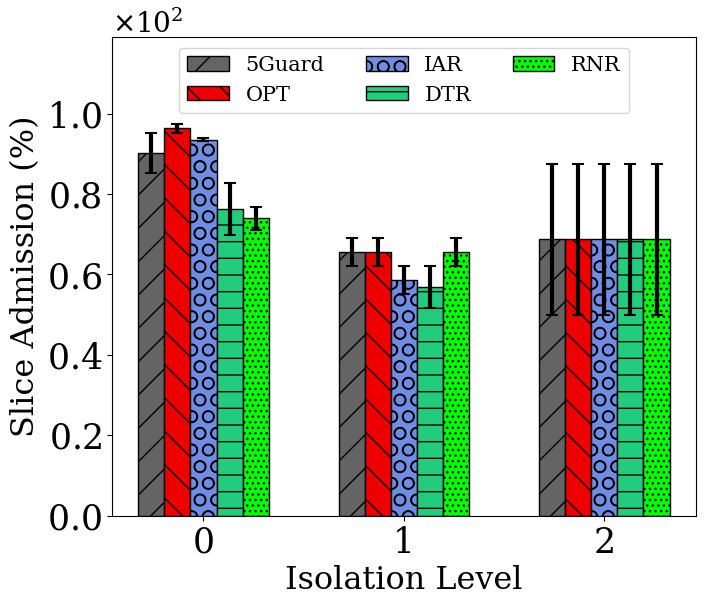

In [33]:
fig, ax = plt.subplots(figsize=(7, 6))
positions = [np.arange(3) + i * bar_width for i in range(len(algs))]

for i, alg in enumerate(algs):
    NUM_L0_SR = sr_type_list.count(0) + sr_type_list.count(2)
    NUM_L1_SR = sr_type_list.count(1)
    NUM_L2_SR = sr_type_list.count(3)
    denominator = np.clip([NUM_L0_SR, NUM_L1_SR, NUM_L2_SR], 1e-9, None)
    
    values = (1 - np.sum(np.array(ypoints[alg]["reject"]), axis=0) / denominator) * 100
    values = [min(a, b) for a, b in zip(values, [100, 100, 100])]

    #print(data[alg]["reject"])
    # Extracting error values
    err_low  = values - list([np.min((1 - np.sum(np.array(data[alg]["reject"]), axis=1) / denominator), axis=0) * 100])[0]
    err_high = list([np.max((1 - np.sum(np.array(data[alg]["reject"]), axis=1) / denominator), axis=0) * 100])[0] - values
    
    # Adding bars with error bars
    ax.bar(positions[i], values, width=bar_width, color=colors[i], edgecolor='black', hatch=patterns[i],
           yerr=[err_low, err_high], capsize=5, error_kw={'elinewidth': 3, 'capthick': 1.5, 'capsize': 4})

ax.set_xticks(positions[2])
ax.set_xticklabels(['0', '1', '2'])
ax.set_ylim(top=119)

ax.tick_params(axis='both', labelsize=tick_label_size)
ax.legend(['5Guard', 'OPT', 'IAR', 'DTR', 'RNR'], fontsize=legend_font_size-3, loc='upper center', ncol=3)

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.offsetText.set_fontsize(20)  # Adjust font size

ax.set_xlabel(plot_titles[0][0], fontsize=xlabel_font_size)
ax.set_ylabel(plot_titles[0][1], fontsize=ylabel_font_size)
fig.tight_layout(pad=0.5)
plt.savefig(f"plots/result_{0}.svg", format="svg")

## Profit and Cumulative Migration 

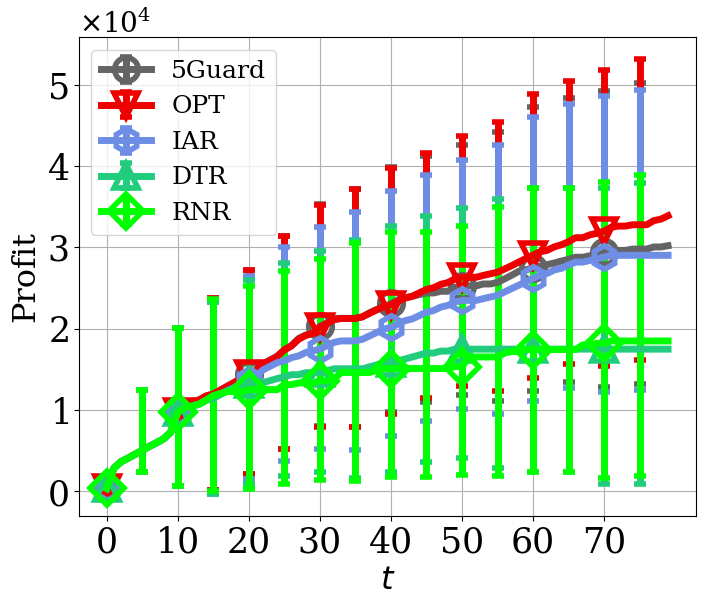

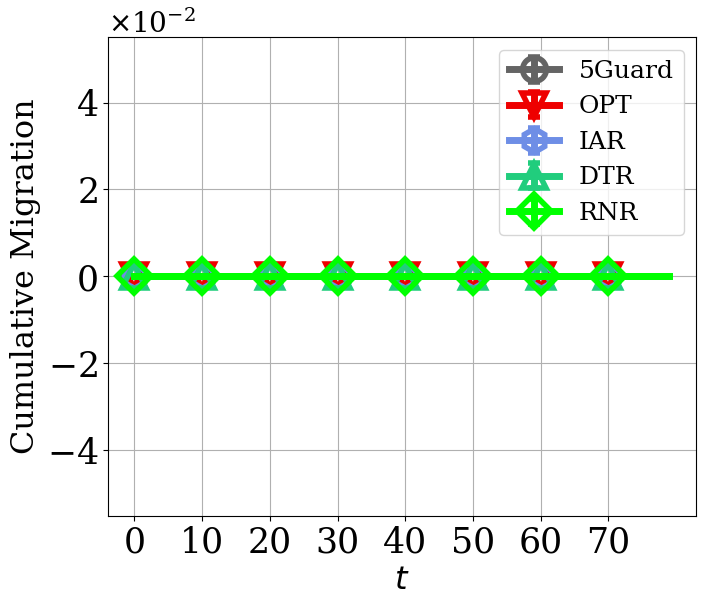

In [35]:
for idx_k, k in enumerate(kpis2):
    fig, ax = plt.subplots(figsize=(7, 6))

    for i, alg in enumerate(algs):
        ax.errorbar(xpoints, ypoints[alg][k],  
                    yerr=(np.where(np.arange(len(xpoints)) % step == 0, yerrors_low[alg][k], np.nan),  
                          np.where(np.arange(len(xpoints)) % step == 0, yerrors_high[alg][k], np.nan)),  
                    marker=markers[i], markevery=markevery, markersize=marker_size,
                    color=colors[i], linewidth=linewidth, markerfacecolor='none', markeredgecolor=colors[i],
                    markeredgewidth=markeredgewidth, capsize=4, capthick=1, linestyle='-')
    ax.grid()
    
    plt.xticks(np.arange(0, T_START+SIMULATION_INTERVAL, step=10))

    ax.tick_params(axis='both', labelsize=tick_label_size)
    ax.legend(['5Guard', 'OPT', 'IAR', 'DTR', 'RNR'], fontsize=legend_font_size)

    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.get_major_formatter().set_scientific(True)
    ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
    ax.yaxis.offsetText.set_fontsize(20)  # Adjust font size
    
    ax.set_xlabel(plot_titles[idx_k+1][0], fontsize=xlabel_font_size)
    ax.set_ylabel(plot_titles[idx_k+1][1], fontsize=ylabel_font_size)
    fig.tight_layout(pad=0.5)
    plt.savefig(f"plots/result_{idx_k+1}.svg", format="svg")

## Allocation Time

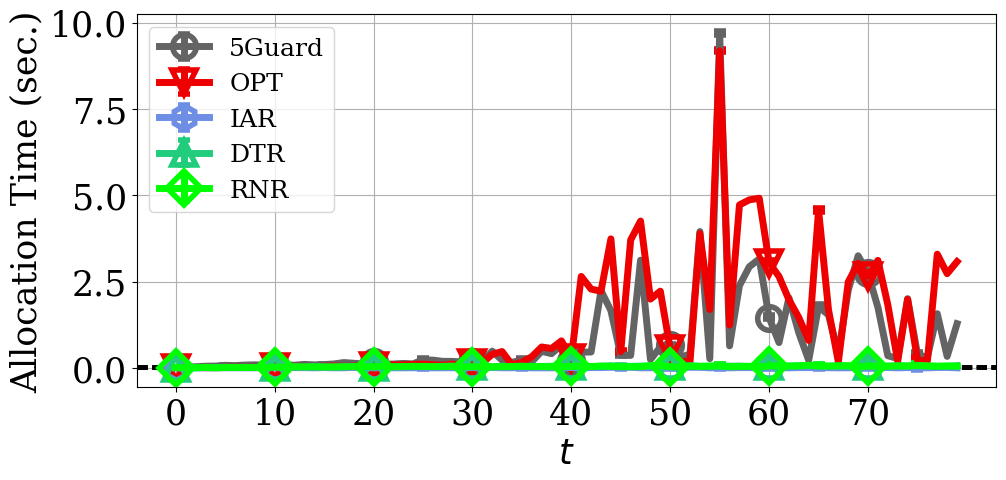

In [37]:
xpoints = range(0, T_START+SIMULATION_INTERVAL)
kpi     = "time"
colors  = ["#646464", "#EE0000", "#6E8EE6", "#21CD7D", "#00FF00"]
markers = ['o', 'v', 'h', '^', 'D']
limits  = np.array([4, 5, 1, 0.5])*0.01

# Plot setup
fig, ax = plt.subplots(figsize=(10, 4.75))
for i, alg in enumerate(algs):
    # ax.errorbar(xpoints, ypoints[alg][kpi], 
    #                 yerr=(yerrors_low[alg][kpi], yerrors_high[alg][kpi]),  # Asymmetric error bars
    #                 marker=markers[i], markevery=10, markersize=marker_size,
    #                 color=colors[i], linewidth=linewidth, markerfacecolor='none', markeredgecolor=colors[i],
    #                 markeredgewidth=markeredgewidth, capsize=4, capthick=1, linestyle='-')
    ax.errorbar(xpoints, ypoints[alg][kpi],  
                    yerr=(np.where(np.arange(len(xpoints)) % step == 0, yerrors_low[alg][kpi], np.nan),  
                          np.where(np.arange(len(xpoints)) % step == 0, yerrors_high[alg][kpi], np.nan)),  
                    marker=markers[i], markevery=markevery, markersize=marker_size,
                    color=colors[i], linewidth=linewidth, markerfacecolor='none', markeredgecolor=colors[i],
                    markeredgewidth=markeredgewidth, capsize=4, capthick=1, linestyle='-')
    

# Formatting
ax.grid()
ax.tick_params(axis='both', labelsize=25)
ax.legend(['5Guard', 'OPT', 'IAR', 'DTR', 'RNR'], fontsize=18)
ax.set_xlabel('$\it{t}$', fontsize=25)
ax.set_ylabel('Allocation Time (sec.)', fontsize=25)
ax.set_xticks(np.arange(0, T_START+SIMULATION_INTERVAL, step=10))

# Add dashed limit lines
for limit in limits:
    ax.axhline(y=limit, color='#000000', linestyle='--', linewidth=2)
    
fig.tight_layout(pad=0.5)

# Save & show
plt.savefig("plots/result_8.svg", format="svg")
plt.show()

## Violation, Deployment, and Overhead Costs and Resource Efficiency

ValueError: 'yerr' must not contain negative values

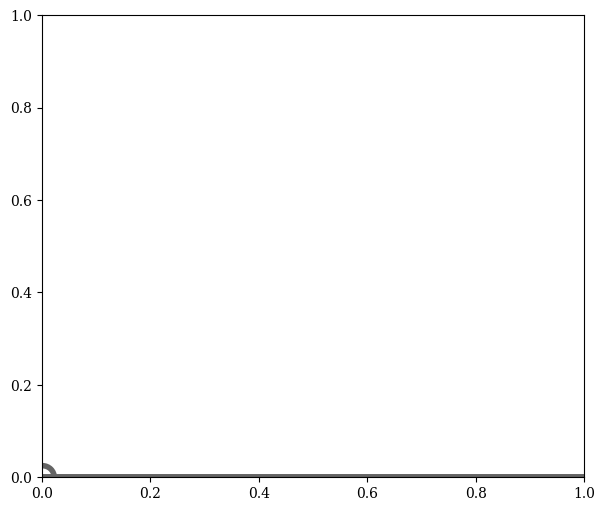

In [39]:
for idx_k, k in enumerate(kpis3):
    fig, ax = plt.subplots(figsize=(7, 6))
    
    for i, alg in enumerate(algs):
        ax.errorbar(xpoints, ypoints[alg][k][:,0],  
                    yerr=(np.where(np.arange(len(xpoints)) % step == 0, yerrors_low[alg][k][:,0], np.nan),  
                          np.where(np.arange(len(xpoints)) % step == 0, yerrors_high[alg][k][:,0], np.nan)),  
                    marker=markers[i], markevery=markevery, markersize=marker_size,
                    color=colors[i], linewidth=linewidth, markerfacecolor='none', markeredgecolor=colors[i],
                    markeredgewidth=markeredgewidth, capsize=4, capthick=1, linestyle='-')
    ax.grid()
    
    plt.xticks(np.arange(0, T_START+SIMULATION_INTERVAL, step=10))

    ax.tick_params(axis='both', labelsize=tick_label_size)
    ax.legend(['5Guard', 'OPT', 'IAR', 'DTR', 'RNR'], fontsize=legend_font_size)

    if k != "reseff": ## Percentage data
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.yaxis.get_major_formatter().set_scientific(True)
        ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
        ax.yaxis.offsetText.set_fontsize(20)  # Adjust font size
    
    ax.set_xlabel(plot_titles[idx_k+3][0], fontsize=xlabel_font_size)
    ax.set_ylabel(plot_titles[idx_k+3][1], fontsize=ylabel_font_size)
    fig.tight_layout(pad=0.5)
    plt.savefig(f"plots/result_{idx_k+3}.svg", format="svg")

plt.show()